<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# GAN Example
In this demo notebook we are going to demonstrate the creation and use of a Generative Adversarial Network as implemented in the [original GAN paper by Goodfellow et al.](https://arxiv.org/pdf/1406.2661.pdf) For demonstration purposes, our objective will be to create a GAN which is trained on MNIST and able to generate images of handwritten digits.

**Notes:**
- This notebook should be run on GPU

**References:**
- Read the [original GAN paper](https://arxiv.org/pdf/1406.2661.pdf) for details on the training process  
- This implementation is based on the [implementation by Raschka et al. in Machine Learning with PyTorch and Scikit-Learn](https://github.com/rasbt/machine-learning-book)

In [ ]:
# Run this cell only if working in Colab
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "AIPI540-Deep-Learning-Applications" # Enter repo name
git_path = 'https://github.com/AIPI540/AIPI540-Deep-Learning-Applications.git'
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}"

# Change working directory to location of notebook
notebook_dir = '2_computer_vision/GANs'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

In [37]:
import os
import numpy as np
import torch
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, TensorDataset

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

torch.manual_seed(1)

TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = "cpu"

torch:  1.10 ; cuda:  1.10.1


### Get data and set up dataloaders

In [32]:
# Download the data
if not os.path.exists('./data'):
    os.mkdir('./data')

# Apply transforms to convert to tensor and normalize pixel values to range [-1,1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5)),
])

# Create Dataset
train_data = datasets.MNIST(root='data', train=True, transform=transform, download=True)

# Create DataLoader
batch_size = 64
trainloader = DataLoader(train_data, batch_size, shuffle=False)

# Check an example
img, label = next(iter(train_data))
print(f'Min: {img.min()} Max: {img.max()}')
print(f'Shape: {img.shape}')

Min: -1.0 Max: 1.0
Shape: torch.Size([1, 28, 28])


### Define architecture of generator and discriminator

In [24]:
def make_generator_network(
        input_size=20,
        num_hidden_layers=1,
        num_hidden_units=100,
        num_output_units=784):
    # Define the generator architecture

    model = nn.Sequential()

    # Add linear hidden layers with LeakyReLU activations
    for i in range(num_hidden_layers):
        model.add_module(f'fc_g{i}', nn.Linear(input_size, num_hidden_units)) 
        model.add_module(f'relu_g{i}', nn.LeakyReLU())     
        input_size = num_hidden_units

    # Add linear output layer with hyperbolic tangent activation
    model.add_module(f'fc_g{num_hidden_layers}', nn.Linear(input_size, num_output_units))   
    model.add_module('tanh_g', nn.Tanh())      

    return model

In [25]:
def make_discriminator_network(
        input_size,
        num_hidden_layers=1,
        num_hidden_units=100,
        num_output_units=1):
    # Define the discriminator architecture

    # Add linear hidden layers with LeakyReLU activation and dropout
    model = nn.Sequential()
    for i in range(num_hidden_layers):
        model.add_module(f'fc_d{i}', nn.Linear(input_size, num_hidden_units, bias=False)) 
        model.add_module(f'relu_d{i}', nn.LeakyReLU())  
        model.add_module('dropout', nn.Dropout(p=0.5))
        input_size = num_hidden_units

    # Add linear output layer with sigmoid activation
    model.add_module(f'fc_d{num_hidden_layers}', nn.Linear(input_size, num_output_units))   
    model.add_module('sigmoid', nn.Sigmoid())
    
    return model

In [26]:
# Instantiate the generator and discriminator
image_size = (28, 28)
z_size = 20

gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

gen_model = make_generator_network(
    input_size=z_size,
    num_hidden_layers=gen_hidden_layers, 
    num_hidden_units=gen_hidden_size,
    num_output_units=np.prod(image_size))
 
print(gen_model)

Sequential(
  (fc_g0): Linear(in_features=20, out_features=100, bias=True)
  (relu_g0): LeakyReLU(negative_slope=0.01)
  (fc_g1): Linear(in_features=100, out_features=784, bias=True)
  (tanh_g): Tanh()
)


In [27]:
# Make discriminator
disc_model = make_discriminator_network(
    input_size=np.prod(image_size),
    num_hidden_layers=disc_hidden_layers,
    num_hidden_units=disc_hidden_size)

print(disc_model)

Sequential(
  (fc_d0): Linear(in_features=784, out_features=100, bias=False)
  (relu_d0): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_d1): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


### Define loss functions and optimizers

In [28]:
# Use binary cross entropy loss (NLL) for both generator and discriminator
loss_fn = nn.BCELoss()

# Use Adam optimizers
g_optimizer = torch.optim.Adam(gen_model.parameters())
d_optimizer = torch.optim.Adam(disc_model.parameters())

### Set up training loop

In [29]:
def create_noise(batch_size, z_size, mode_z):
    # Create a batch of z inputs to generate fake images

    if mode_z == 'uniform':
        input_z = torch.rand(batch_size, z_size)*2 - 1 
    elif mode_z == 'normal':
        input_z = torch.randn(batch_size, z_size)
        
    return input_z

In [34]:
def train_discriminator(x,disc_model,gen_model,mode_z,loss_fn):
    # Train discriminator for one step
    
    disc_model.zero_grad()

    # Train with a batch of real images
    batch_size = x.size(0)
    x = x.view(batch_size, -1).to(device)
    d_labels_real = torch.ones(batch_size, 1, device=device)

    # Get predictions on the real images and calculate loss
    d_proba_real = disc_model(x)
    d_loss_real = loss_fn(d_proba_real, d_labels_real)

    # Train discriminator on a batch of fake images
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    
    d_proba_fake = disc_model(g_output)
    d_labels_fake = torch.zeros(batch_size, 1, device=device)
    d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

    # Add the loss on the real and fake images and backpropagate it across the discriminator
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()
  
    return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()

In [39]:
def train_generator(x,disc_model,gen_model,mode_z,loss_fn):
    # Train generator for one step

    gen_model.zero_grad()
    
    # Create batch of z inputs and labels (switched so label is 1)
    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_labels_real = torch.ones(batch_size, 1, device=device)

    # Pass the z inputs through the generator, get predictions and calculate loss
    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    g_loss = loss_fn(d_proba_fake, g_labels_real)

    # Backpropagate the loss across the generator
    g_loss.backward()
    g_optimizer.step()
        
    return g_loss.data.item()

### Run training and create samples from generator each epoch

In [41]:
# Get a fixed set of z inputs to generate images from after each epoch of training
# This will show us how the generator improves over time
mode_z = 'uniform'
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)

def create_samples(g_model, batch_size, image_size, input_z):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))    
    return (images+1)/2.0


epoch_samples = []
all_d_losses = []
all_g_losses = []
all_d_real = []
all_d_fake = []

# Run training loop
epochs = 5
for epoch in range(epochs):           
    d_losses, g_losses = [], []
    d_vals_real, d_vals_fake = [], []
    for i, (x, _) in enumerate(trainloader):
        # Train the discriminator first
        d_loss, d_proba_real, d_proba_fake = train_discriminator(x,disc_model,gen_model,mode_z,loss_fn)
        d_losses.append(d_loss)
        # Train generator
        g_loss = train_generator(x,disc_model,gen_model,mode_z,loss_fn)
        g_losses.append(g_loss)
        
        d_vals_real.append(d_proba_real.mean().cpu())
        d_vals_fake.append(d_proba_fake.mean().cpu())
        
    # Store the average losses and the average probability of real and fake for each epoch
    all_d_losses.append(torch.tensor(d_losses).mean())
    all_g_losses.append(torch.tensor(g_losses).mean())
    all_d_real.append(torch.tensor(d_vals_real).mean())
    all_d_fake.append(torch.tensor(d_vals_fake).mean())

    print(f'Epoch {epoch:03d} | Avg Losses >>'
          f' G/D {all_g_losses[-1]:.3f}/{all_d_losses[-1]:.3f}'
          f' [D-Real: {all_d_real[-1]:.3f} D-Fake: {all_d_fake[-1]:.3f}]')

    # Create samples each epoch using generator on fixed z input batch to show progress
    epoch_samples.append(create_samples(gen_model, batch_size, image_size, fixed_z).detach().cpu().numpy())


Epoch 000 | Avg Losses >> G/D 0.893/0.951 [D-Real: 0.777 D-Fake: 0.474]
Epoch 001 | Avg Losses >> G/D 0.820/1.254 [D-Real: 0.564 D-Fake: 0.466]
Epoch 002 | Avg Losses >> G/D 0.872/1.227 [D-Real: 0.567 D-Fake: 0.442]
Epoch 003 | Avg Losses >> G/D 1.035/1.142 [D-Real: 0.603 D-Fake: 0.400]
Epoch 004 | Avg Losses >> G/D 0.945/1.206 [D-Real: 0.582 D-Fake: 0.423]


### Visualize the training results

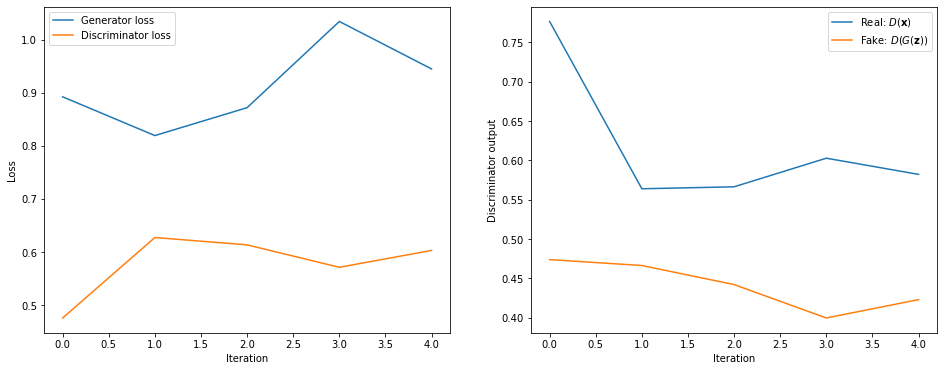

In [45]:
fig = plt.figure(figsize=(16, 6))

## Plotting the losses
ax = fig.add_subplot(1, 2, 1)
 
plt.plot(all_g_losses, label='Generator loss')
half_d_losses = [all_d_loss/2 for all_d_loss in all_d_losses]
plt.plot(half_d_losses, label='Discriminator loss')
plt.legend()
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')

## Plotting the outputs of the discriminator
ax = fig.add_subplot(1, 2, 2)
plt.plot(all_d_real, label=r'Real: $D(\mathbf{x})$')
plt.plot(all_d_fake, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend()
ax.set_xlabel('Iteration')
ax.set_ylabel('Discriminator output')

plt.show()

In [ ]:
# Visualize some generated images after select epochs to show progress of generator training
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')
    
plt.show()